<a href="https://colab.research.google.com/github/Virajbiz98/Python_Learning/blob/main/LangGraph/chatbot_an_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain==0.3.24 -q
!pip install openai -q
# !pip install -q -U google-generativeai
!pip install langgraph -q
!pip install langchain_openai -q

In [ ]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage

In [ ]:
class Agentstate(TypedDict):
  messages: List[HumanMessage]

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = "gpt-4.1",
    temperature=0
)

In [ ]:
def chatbot(state: Agentstate) -> Agentstate:
  response = llm.invoke(state["messages"])
  print(f"\nAI: {response.content}")
  return state

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(Agentstate)

workflow.add_node("chatbot", chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

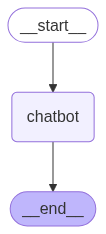

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
user_input = input("Enter a Query: ")
result = app.invoke({"messages": [HumanMessage(content=user_input)]})
print(result)

Enter a Query: exit


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
from IPython import get_ipython
from IPython.display import display

!pip install langchain==0.3.24 -q
!pip install -q -U google-generativeai
!pip install langgraph -q
!pip install langchain_google_genai -q

In [ ]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage



In [ ]:

class Agentstate(TypedDict):
  messages: List[Union[HumanMessage,AIMessage]]

In [ ]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    temperature=0
)

In [ ]:

def chatbot(state: Agentstate) -> Agentstate:
  response = llm.invoke(state["messages"])
  state["messages"].append(AIMessage(content=response.content))
  print(f"\nAI: {response.content}")
  return state

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(Agentstate)

workflow.add_node("chatbot", chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:

user_input = input("Enter a Query: ")
result = app.invoke({"messages": [HumanMessage(content=user_input)]})
print(result)

In [ ]:
history = []

user_input = input("Enter a Query: ")
while user_input != "exit":
  history.append(HumanMessage(content=user_input))
  result = app.invoke({"messages": history } )
  history = result["messages"]
  user_input = input("Enter a Qeury: ")

Agent

In [108]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [116]:
class AgentState(TypedDict):
  messages:Annotated[Sequence[BaseMessage], add_messages]

In [117]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [118]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash"
)

In [119]:
@tool
def addition(a: int, b: int):
  """This is the addition function that adds 2 numbers"""
  return a + b

@tool
def subtraction(a: int, b: int):
  """This is the subtraction function that subtract 2 numbers"""
  return a - b

@tool
def multiplication(a: int, b: int):
  """This is the multiplication function that multiply 2 numbers"""
  return a * b

@tool
def division(a: int, b: int):
  """This is the division function that divide 2 numbers"""
  return a / b

In [120]:
tools = [addition, subtraction, multiplication, division]

In [121]:
llm_with_tools = llm.bind_tools(tools)

In [122]:
def llm_call(state:AgentState) -> AgentState:
  system_prompt = SystemMessage(content=
                                "You are an intelligent AI assistant, Please answer my query."
                                )
  response = llm_with_tools.invoke([system_prompt] + state["messages"])
  return {"messages": [response]}

In [124]:
def decision_node(state: AgentState):
  messages = state["messages"]
  last_message = messages[-1]
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"


In [125]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    decision_node,
    {
        "continue": "tools",
        "end": END,

    },
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

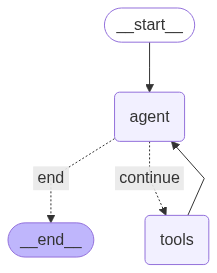

In [126]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [127]:
def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)
    else:
      message.pretty_print()

In [131]:
inputs = {"messages": [("user", "ADD 40 and 12. and then multiply by 2 ")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

ADD 40 and 12. and then multiply by 2 
================================== Ai Message ==================================
Tool Calls:
  addition (38e21f05-038f-4a12-bec9-cd1738034d06)
 Call ID: 38e21f05-038f-4a12-bec9-cd1738034d06
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: addition

52
================================== Ai Message ==================================
Tool Calls:
  multiplication (bc09b616-d247-4173-b03d-ffe7266d043b)
 Call ID: bc09b616-d247-4173-b03d-ffe7266d043b
  Args:
    a: 52.0
    b: 2.0
================================= Tool Message =================================
Name: multiplication

104
================================== Ai Message ==================================

The answer is 104


Search Wheather

In [143]:
!pip install duckduckgo-search -qU
!pip install pyowm -qU
!pip install langchain-community -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.9 MB/s eta 0:00:00


In [145]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools
import os

os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')

# Initialize DuckDuckGo search tool
search_tool = DuckDuckGoSearchRun()

# Initialize OpenWeatherMap tool
weather = OpenWeatherMapAPIWrapper()

wheather_tool = load_tools(["openweathermap-api"], llm)[0]

In [146]:
tools = [search_tool, wheather_tool]

In [147]:
llm_with_tools = llm.bind_tools(tools)

In [148]:
def llm_call(state:AgentState) -> AgentState:
  system_prompt = SystemMessage(
      content=
      "You are an intelligent AI assistant, please answer my query."
  )
  response = llm_with_tools.invoke([system_prompt] + state["messages"])
  return {"messages" : [response]}

In [149]:
def decision_node(state: AgentState):
  messages = state["messages"]
  last_message = messages[-1]
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [151]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)

tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    decision_node,
    {
        "continue": "tools",
        "end" : END,
    },
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

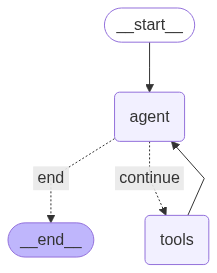

In [152]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [153]:
def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)
    else:
      message.pretty_print()


In [157]:
inputs = {"messages" : [("user", "current weather in candy")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

current weather in candy
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (819e8c1c-dd8f-4236-a0e9-f69b62604e2c)
 Call ID: 819e8c1c-dd8f-4236-a0e9-f69b62604e2c
  Args:
    location: Candy
================================= Tool Message =================================
Name: open_weather_map

In Candy, the current weather is as follows:
Detailed status: light rain
Wind speed: 6.83 m/s, direction: 236°
Humidity: 78%
Temperature: 
  - Current: 17.03°C
  - High: 17.16°C
  - Low: 17.03°C
  - Feels like: 16.83°C
Rain: {'1h': 0.12}
Heat index: None
Cloud cover: 100%
================================== Ai Message ==================================

OK. The current weather in Candy is light rain. The temperature is 17.03°C, but it feels like 16.83°C. The wind speed is 6.83 m/s from 236°. The humidity is 78% and there is 100% cloud cover.


In [156]:
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is agentic ai
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (5d77febe-cb96-4bd4-931f-01f1e3022e38)
 Call ID: 5d77febe-cb96-4bd4-931f-01f1e3022e38
  Args:
    query: agentic AI
================================= Tool Message =================================
Name: duckduckgo_search

Agentic AI is a new generation of AI systems that can act and reason autonomously. Learn how agentic AI can transform work, and what challenges and opportunities it brings for businesses and society. Agentic AI uses reasoning and planning to solve complex problems and interact with various tools and data sources. Learn how agentic AI works, its applications and how to get started with NVIDIA Blueprints. Agentic AI is a type of AI that operates autonomously, making decisions and taking actions based on its understanding of the environment and predefined objec

In [159]:
inputs = {"messages" : [("user", "who the richest man in sri lanka")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

who the richest man in sri lanka
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (8db9fe9f-5bfb-4ea9-971f-65c96ebfe818)
 Call ID: 8db9fe9f-5bfb-4ea9-971f-65c96ebfe818
  Args:
    query: who is the richest man in sri lanka
================================= Tool Message =================================
Name: duckduckgo_search

Richest people in Sri Lanka One of Sri Lankan's richest people is Dhammika Pereras, a businessman who is owning about 23 companies in various sectors and whose estimated fortune amounts to 550 ... Discover the stories of Sri Lanka's top business moguls who've transformed industries, uplifted communities, and left an indelible mark on the nation's econo... The claim that Anura Kumara Dissanayake is the eighth richest person in Sri Lanka is false and lacks any credible evidence or support from official records. His public

In [160]:
inputs = {"messages" : [("user", "current weather in california")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

current weather in california
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (15c2695e-6658-47eb-962d-ecf9fc866a08)
 Call ID: 15c2695e-6658-47eb-962d-ecf9fc866a08
  Args:
    location: California
================================= Tool Message =================================
Name: open_weather_map

In California, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 0 m/s, direction: 0°
Humidity: 98%
Temperature: 
  - Current: 19.65°C
  - High: 21.48°C
  - Low: 19.03°C
  - Feels like: 20.23°C
Rain: {}
Heat index: None
Cloud cover: 100%
================================== Ai Message ==================================

OK. The current weather in California is overcast clouds. The temperature is 19.65°C, but it feels like 20.23°C. The high for today is 21.48°C and the low is 19.03°C. The wind is 0 m/s from 0 degrees an

RAG_APP

In [163]:
!pip install langchain_chroma -q
!pip install pypdf -q
!pip install langgraph -q

In [165]:
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [166]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [167]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0
)

In [179]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)

In [180]:
pdf_loader = PyPDFLoader("/content/rsch_pdf_30305836.pdf")

In [171]:
pages = pdf_loader.load()

In [174]:
pages

[Document(metadata={'producer': 'Aspose.PDF for Java 24.6', 'creator': 'Aspose Pty Ltd.', 'creationdate': '2025-01-17T16:35:40+00:00', 'author': 'Gibson, Carol [ICG-CGI]', 'gpstext': 'GLOBAL POTENTIAL SOURCES', 'company': 'CITI', 'producttranslation': 'Original', 'templateversion': '1.0.1', 'msip_label_dd181445-6ec4-4473-9810-00785f082df0_actionid': '444c54a3-acea-481a-a036-d2b0cfddda97', 'reportdate': 'January 2025', 'gps': 'GPS', 'msip_label_dd181445-6ec4-4473-9810-00785f082df0_name': 'Internal', 'favesessionid': 'd81041e4-954e-4987-be57-72b57b8d9384', 'msip_label_dd181445-6ec4-4473-9810-00785f082df0_method': 'Privileged', 'solution id': 'None', 'productpublishinggroup': 'GPS', 'msip_label_dd181445-6ec4-4473-9810-00785f082df0_siteid': '1771ae17-e764-4e0f-a476-d4184d79a5d9', 'productstream': 'FAVE', 'moddate': '2025-01-17T11:57:37-05:00', 'productlanguage': 'en', 'basewrap': 'CIRB1130', 'ciradocversion': '2016', 'productcode': 'GPS', 'productsubtype': 'GPS', 'sector': 'ECONOMICS', 'ms

In [181]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
    )


In [182]:
pages_split = text_splitter.split_documents(pages)

In [183]:
len(pages_split)

149

In [185]:
vectorstore = Chroma.from_documents(
    documents=pages_split,
    embedding=embeddings,
    persist_directory=".vectorstore",
    collection_name="data"
)

In [189]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [191]:
@tool
def retriever_tool(query: str) -> str:
  """
  This tool searches and returns the information about AGENTIC AI:Finance & the ‘Do It For Me’ Economy.
  """
  docs = retriever.invoke(query)
  if not docs:
    return "I found no relevent information"
  results = []
  for i, doc in enumerate(docs):
    results.append(f"Document {i+1}:\n{doc.page_content}")

  return "\n\n".join(results)

In [192]:
tools = [retriever_tool]

llm_with_tools = llm.bind_tools(tools)

In [215]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [216]:
def should_continue(state: AgentState):
  """Check if the last message contains tool calls."""
  result = state['messages'][-1]
  return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [217]:
system_prompt = """
You are an intelligent AI assistant who answers questions about AGENTIC AI: Finance & the ‘Do It For Me’ Economy based on the provided documents.
Your primary function is to process user queries related to this topic and provide informative responses by utilizing the available tools, specifically the retriever tool, to search the document content.
If a query is outside the scope of Agentic AI in Finance and the 'Do It For Me' Economy, inform the user that you can only answer questions related to this specific topic.
When answering, synthesize information from the retrieved documents to provide a comprehensive and accurate response.
If the retriever tool does not return relevant information for a query that is within the scope, state that you could not find relevant information in the provided documents.
"""

In [218]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [219]:
#LLM Agent
def call_llm(state: AgentState) -> AgentState:
  """Function to call the LLM with the current state."""
  messages = list(state['messages'])
  messages = [SystemMessage(content=system_prompt)] + messages
  message = llm_with_tools.invoke(messages)
  print(message)
  return {'messages':[message]}

In [220]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
  """Execute tool calls from the LLM's response."""

  tool_calls = state["messages"][-1].tool_calls
  results = []
  for t in tool_calls:
    print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

    if not t['name'] in tools_dict:
       # Checks if a valid tool is present
      print(f"\Tool: {t['name']} does not exist.")
      result = "Incorrect Tool Name. Please Retry and Select a tool from List of Available tools."

    else:
      result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
      print(f"Result length: {len(str(result))}")

    # Appends the Tool Message

    results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

  print("Tools Execution Comlete. Back to the model!")
  return {'messages': results} #

In [221]:
workflow = StateGraph(AgentState)

workflow.add_node('llm', call_llm)
workflow.add_node('retriever_agent', take_action)

workflow.add_edge(START, 'llm')
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        True: "retriever_agent",
        False: END,
    }
)
workflow.add_edge("retriever_agent", "llm")

app = workflow.compile()


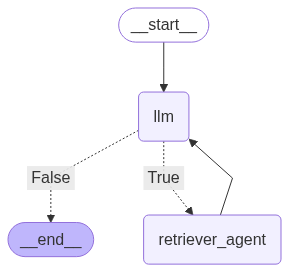

In [222]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [224]:
result = app.invoke({"messages": [HumanMessage(content="who writed AGENTIC AI: Finance & the ‘Do It For Me’ Economy")]})

content='I am sorry, I cannot answer this question based on the available tools.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--8e023336-9b32-436c-ae63-94a34b23c474-0' usage_metadata={'input_tokens': 203, 'output_tokens': 16, 'total_tokens': 219, 'input_token_details': {'cache_read': 0}}


In [227]:
result = app.invoke({"messages": [HumanMessage(content="What is the role of Agentic AI in finance?")]})
print(result)

content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "role of Agentic AI in finance"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--73b85a8d-7b0f-43fd-b78c-2f708608c9b4-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'role of Agentic AI in finance'}, 'id': 'a66c5699-30e9-4388-94cd-7bc930042be0', 'type': 'tool_call'}] usage_metadata={'input_tokens': 197, 'output_tokens': 12, 'total_tokens': 209, 'input_token_details': {'cache_read': 0}}
Calling Tool: retriever_tool with query: role of Agentic AI in finance
Result length: 2870
Tools Execution Comlete. Back to the model!
content='Agentic AI has several use cases in finance, and is likely to become part of daily workflows in our personal and professional lives. The applications range from self-driving assistants to self-driving automobiles and beyond. Some s

In [226]:
result = app.invoke({"messages": [HumanMessage(content="What are the key benefits of Agentic AI in the financial sector?")]})
print(result)

content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "key benefits of Agentic AI in the financial sector"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--bd61b06b-0084-4963-9e27-03ce52d9913e-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'key benefits of Agentic AI in the financial sector'}, 'id': 'f95a1405-c0b4-4c67-b73c-d2ca99a3bc0d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 200, 'output_tokens': 15, 'total_tokens': 215, 'input_token_details': {'cache_read': 0}}
Calling Tool: retriever_tool with query: key benefits of Agentic AI in the financial sector
Result length: 2639
Tools Execution Comlete. Back to the model!
content='Agentic AI in the financial sector delivers higher-quality output faster than traditional methods. It is well-suited for automating complex, data-driven workflows that 

In [228]:
input = app.invoke({"messages": [HumanMessage(content="Can you provide some examples of companies using Agentic AI in finance mentioned in the document?")]})
print(input)

content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "companies using Agentic AI in finance"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--874b703f-232a-4b6c-a8b9-1a016f2ea1ae-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'companies using Agentic AI in finance'}, 'id': '1ca7f220-4bea-453f-b496-7879b353ba02', 'type': 'tool_call'}] usage_metadata={'input_tokens': 204, 'output_tokens': 12, 'total_tokens': 216, 'input_token_details': {'cache_read': 0}}
Calling Tool: retriever_tool with query: companies using Agentic AI in finance
Result length: 2236
Tools Execution Comlete. Back to the model!
content='The document mentions that banks and financial firms are proceeding with caution but are still doing more than many may have expected in adopting AI. It highlights that the financial services sector is one o

In [229]:
inputs = app.invoke({"messages": [HumanMessage(content="What is the capital of France?")]})
print(inputs)

content='I can only answer questions related to AGENTIC AI: Finance & the ‘Do It For Me’ Economy.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--2a2c8c58-e97c-4008-8f9d-487c02d0e708-0' usage_metadata={'input_tokens': 193, 'output_tokens': 23, 'total_tokens': 216, 'input_token_details': {'cache_read': 0}}
{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}), AIMessage(content='I can only answer questions related to AGENTIC AI: Finance & the ‘Do It For Me’ Economy.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2a2c8c58-e97c-4008-8f9d-487c02d0e708-0', usage_metadata={'input_tokens': 193, 'output_tokens': 23, 'total_tokens': 216, 'input_tok